In [74]:
import bs4
from bs4 import BeautifulSoup  
import pandas as pd
import scipy as sc
import numpy as np

#crawlng
import requests
import selenium
from selenium import webdriver
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.webdriver.common.by import By
import time
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

import re
import os

#machine learning
import sklearn 
from sklearn import preprocessing, metrics, naive_bayes, pipeline, feature_extraction
from sklearn.feature_extraction import text
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline
from sklearn import neighbors, tree, ensemble, naive_bayes, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#EDA, visualisation and text analysis
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
import seaborn as sns

In [157]:
webdriver_path=r"C:\Users\hadar\Documents\chromedriver_win32\chromedriver.exe"

##########
#general functions
##########

In [11]:
#load csv file to dataframe
def load_csv(file_name):
    df = pd.read_csv(file_name)
    return df

In [12]:
#load soup object from html site
def load_soup_object(html_file_name):
    page=requests.get(html_file_name)
    soup=BeautifulSoup(page.content,'html.parser')
    return soup

In [13]:
#write list to file. One cell per line (for url's lists)
def write_list_to_file(file_name,list_name):
    with open(file_name, 'a') as f:
        for li in list_name:
            f.write("%s\n" % li)

In [14]:
#read file to list line by line (for url's lists)
def read_list_from_file(file_name):
    with open(file_name,'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

In [ ]:
##crawling section-
#crawler for each website separate to two functions:
#(1) url crawler for the main page
#(2) crawl through the articles and collect data for dataset
#crawling websites of:
#(1) fake news - Empire news
#(2) reliable news - Fox News, NBC News
#(3) associated with misinformation(for prediction) - Israel 365 News, Middle East Monitor
##########

In [41]:
#scapping articles'urls from the website
#scrapping from multiple pages with 'loas more' button 
#used stackoverflow - https://stackoverflow.com/questions/68792444/how-to-scrape-website-if-it-has-load-more-button-to-load-more-content-on-the-pag
def israel365news_crawler(webdriver_path,max_links):
    driver=webdriver.Chrome(executable_path=webdriver_path)
    soup=load_soup_object('https://www.israel365news.com/israel-news/')

    try:
        driver.maximize_window() #ensures that the window occupies the entire screen.
        driver.implicitly_wait(10) #wait for up to 10 seconds for the element to appear before throwing an exception
        driver.get("https://www.israel365news.com/israel-news/")

        urls=[]

        while max_links>=0:
            if max_links%100==0: print(f'{max_links} urls until finish')
            #articles = driver.find_elements_by_css_selector("h1.elementor-heading-title.elementor-size-default")
            #articles=driver.find_elements("xpath", "//h1[@class='elementor-heading-title elementor-size-default']")
            articles=soup('h1',attrs={"class":"elementor-heading-title elementor-size-default"})

            for art in articles:
                #url=art.find_element_by_tag_name("a").get_attribute("href")
                #url = art.find_element("xpath", "./a").get_attribute("href")
                #urls.append(url)
                #print(f'url appended: {url}')
                a=art.find('a')
                try:
                    if 'href' in a.attrs:
                        url=a.get('href')
                        urls.append(url)
                        #print(f'url appended: {url}')
                        max_links-=1
                except:
                    continue

            #loadmore = driver.find_element_by_css_selector("a.elementor-button-link.elementor-button")
            loadmore=driver.find_element("xpath", "//a[contains(@class, 'elementor-button-link') and contains(@class, 'elementor-button')]")

            if loadmore.is_displayed():
                driver.execute_script("arguments[0].click();", loadmore)
                time.sleep(5)
            else:
                print("no more articles to load")
                break

    except StaleElementReferenceException:
        pass

    finally:
        driver.quit()
    return urls


In [42]:
webdriver_path=r"C:\Users\hadar\Documents\chromedriver_win32\chromedriver.exe"
urls_list=israel365news_crawler(webdriver_path,10000)


C:\Users\hadar\AppData\Local\Temp\ipykernel_6828\2713619630.py:5: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome(executable_path=webdriver_path)


10000 urls until finish
9900 urls until finish
9800 urls until finish
9700 urls until finish
9600 urls until finish
9500 urls until finish
9400 urls until finish
9300 urls until finish
9200 urls until finish
9100 urls until finish
9000 urls until finish
8900 urls until finish
8800 urls until finish
8700 urls until finish
8600 urls until finish
8500 urls until finish
8400 urls until finish
8300 urls until finish
8200 urls until finish
8100 urls until finish
8000 urls until finish
7900 urls until finish
7800 urls until finish
7700 urls until finish
7600 urls until finish
7500 urls until finish
7400 urls until finish
7300 urls until finish
7200 urls until finish
7100 urls until finish
7000 urls until finish
6900 urls until finish
6800 urls until finish
6700 urls until finish
6600 urls until finish
6500 urls until finish
6400 urls until finish
6300 urls until finish
6200 urls until finish
6100 urls until finish
6000 urls until finish
5900 urls until finish
5800 urls until finish
5700 urls 

OSError: [Errno 22] Invalid argument: 'https://www.israel365news.com/israel-news/'

In [45]:
write_list_to_file('israel365news_urls.txt',urls_list)

In [111]:
#crawl through all articles from Israel365News we've collected
def load_articles_to_df_israel365news(urls_list):
    headline=[]
    writers=[]
    date=[]
    genre=[]
    content=[]
    i=0
    
    for url in urls_list:
        soup=load_soup_object(url)
        headline.append(soup.find("h1",attrs={"class":"elementor-heading-title elementor-size-default"}).get_text().strip())
        writers.append(soup.find("h4",attrs={"class":"elementor-author-box__name"}).get_text().strip())
        date.append(soup.find("div",attrs={"class":"elementor-element elementor-element-8f04d6d elementor-widget__width-auto elementor-widget elementor-widget-heading"}).find("h2").get_text().strip())
        genre.append(", ".join(item.get_text().strip() for item in soup.find("div",attrs={"class":"elementor-element elementor-element-1a40dbf elementor-widget__width-auto text-hover elementor-widget elementor-widget-heading"}).find_all("a")))
        content.append(soup.find("div",attrs={"class":"elementor-element elementor-element-2106a85 elementor-widget elementor-widget-theme-post-content"}).get_text().strip()) 
        i+=1
        if(i%100==0):
            print(f'{i} articles scrapped')

    df=pd.DataFrame({"headline":headline,"writers":writers,"date":date,"genre":genre,"content":content})
    return df

In [112]:
df=load_articles_to_df_israel365news(urls_list)

100 articles scrapped
200 articles scrapped
300 articles scrapped
400 articles scrapped
500 articles scrapped
600 articles scrapped
700 articles scrapped
800 articles scrapped
900 articles scrapped
1000 articles scrapped
1100 articles scrapped
1200 articles scrapped
1300 articles scrapped
1400 articles scrapped
1500 articles scrapped
1600 articles scrapped
1700 articles scrapped
1800 articles scrapped
1900 articles scrapped
2000 articles scrapped
2100 articles scrapped
2200 articles scrapped
2300 articles scrapped
2400 articles scrapped
2500 articles scrapped
2600 articles scrapped
2700 articles scrapped
2800 articles scrapped
2900 articles scrapped
3000 articles scrapped
3100 articles scrapped
3200 articles scrapped
3300 articles scrapped
3400 articles scrapped
3500 articles scrapped
3600 articles scrapped
3700 articles scrapped
3800 articles scrapped
3900 articles scrapped
4000 articles scrapped
4100 articles scrapped
4200 articles scrapped
4300 articles scrapped
4400 articles scrapp

In [9]:
df.to_csv('israel365news.csv', index=False)

NameError: name 'df' is not defined

In [114]:
df

,headline,writers,date,genre,content
0,Knesset passes 2023-2024 state budget,JNS,"May 24, 2023",Israel News,Israel’s Knesset on Wednesday passed the state...
1,Will flights from Israel to Mecca spark Temple...,Adam Eliyahu Berkowitz,"May 23, 2023",Israel News,Prime Minister Netanyahu was in direct contact...
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,JNS,"May 23, 2023",Israel News,Rabbi Leo Dee is considering suing CNN chief i...
3,Israeli Cabinet boosts funds for Kotel infrast...,JNS,"May 22, 2023",Israel News,The Israeli Cabinet on Sunday approved funding...
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,JNS,"May 21, 2023",Israel News,During a visit to the Temple Mount in Jerusale...
...,...,...,...,...,...
10015,Israeli forces kill two terrorists in raid nea...,JNS,"May 10, 2023","Israel News, Judea and Samaria",Israeli forces killed two Palestinian terroris...
10016,IDF eliminates three top Palestinian Islamic J...,JNS,"May 9, 2023","Israel News, Terror Watch",The Israel Defense Forces killed three top Pal...
10017,"After six years, Israel razes illegal PA struc...",JNS,"May 8, 2023",Israel News,Israel’s Civil Administration demolished a Pal...
10018,Jerusalem Day: Mass return to the Temple Mount...,Adam Eliyahu Berkowitz,"May 7, 2023",Israel News,Temple Mount advocacy groups are planning some...


In [169]:
# making crawler for Middle East Monitor website
def load_articles_url_MEM(n_pages):
    soup=load_soup_object(r'https://www.middleeastmonitor.com/category/news/middle-east/')
    articles=soup("li")
    urls=[]
    
    for page in range(n_pages):
        for art in articles:
            a=art.find('a')
            try:
                if 'href' in a.attrs:
                    url=a.get('href')
                    urls.append(url)
            except:
                continue
        next_page=soup.find("a",attrs={"class":"next page-numbers"})["href"]
        soup=load_soup_object(next_page)
        articles=soup("li")
        if(page%50==0): 
            print(f'{page} pages out of 350')
        
    return urls

In [170]:
mem_urls_list=load_articles_url_MEM(350)

0 pages out of 350
50 pages out of 350
100 pages out of 350
150 pages out of 350
200 pages out of 350
250 pages out of 350
300 pages out of 350


In [32]:
#removing links to other sites from list
for url in mem_urls_list:
    if(url.startswith("https://www.middleeastmonitor.com")==False or len(url)<100 or url.find("category")!=-1 or url.find("6-author")!=-1):
        mem_urls_list.remove(url)
write_list_to_file('mem_urls.txt',mem_urls_list)

In [5]:
mem_urls_list=read_list_from_file('mem_urls.txt')

In [13]:
#crawl through all articles from Israel365News we've collected
def load_articles_to_df_mem(urls_list,start_index,max_urls):
    headline=[]
    writers=[]#there is no authors declared inside the articles, will be filled with Unknown
    date=[]
    genre=[]
    content=[]
    for i in range(max_urls):
        try:
            soup=load_soup_object(urls_list[i+start_index])
            he=soup.find("div",attrs={"id":"post-page-title"}).get_text().strip()
            da=soup.find("span",attrs={"class":"post-page-date"}).get_text().strip()
            ge="+".join(item.get_text().strip() for item in soup.find("div",attrs={"class":"post-meta-top"}).find_all("a"))
            co=" ".join(item.get_text().strip() for item in soup.find("div",attrs={"id":"post-content"}).find_all("p"))
            if he and da and ge and co:
                headline.append(he)
                writers.append("Unknown")
                date.append(da)
                genre.append(ge)
                content.append(co)
            if i%100==0:
                print(f'{i} articles scrapped')
            if not (len(headline)==len(writers)==len(date)==len(genre)==len(content)):
                print(f"problam with url {urls_list[i+start_index]}")
                break
        except:
            continue
    print(f'headlines = {len(headline)}, writers={len(writers)}, date = {len(date)}, genre = {len(genre)}, content={len(content)}')
    df=pd.DataFrame({"headline":headline,"writers":writers,"date":date,"genre":genre,"content":content})
    return df

In [8]:
df_mem=load_articles_to_df_mem(mem_urls_list,0,300)

0 articles scrapped
100 articles scrapped
200 articles scrapped
headlines = 300, writers=300, date = 300, genre = 300, content=300


In [9]:
df_mem

,headline,writers,date,genre,content
0,Reporters Without Borders calls for Egypt to r...,Unknown,"May 27, 2023 at 10:37 am",Africa+Egypt+International Organisations+News+...,Reporters Without Borders has called on the Eg...
1,"Russia, Somalia mull establishment of platform...",Unknown,"May 26, 2023 at 8:11 pm",Africa+Europe & Russia+News+Russia+Somalia,"Somali Foreign Minister, Abshir Omar Jama, sai..."
2,Turkiye homes in northern Syria for voluntary ...,Unknown,"May 26, 2023 at 8:07 pm",Europe & Russia+Middle East+News+Syria+Turkey,Ankara is currently working on the safe return...
3,Lebanon to take steps to fix finance sector sh...,Unknown,"May 26, 2023 at 7:59 pm",Africa+Lebanon+Middle East+News,Lebanon will work over the next year to addres...
4,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,"May 26, 2023 at 6:18 pm",Europe & Russia+Greece+News,Three migrants were killed and twelve others a...
...,...,...,...,...,...
295,Lebanon to take steps to fix finance sector sh...,Unknown,"May 26, 2023 at 7:59 pm",Africa+Lebanon+Middle East+News,Lebanon will work over the next year to addres...
296,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,"May 26, 2023 at 6:18 pm",Europe & Russia+Greece+News,Three migrants were killed and twelve others a...
297,Bahrain schools ordered by King to remove less...,Unknown,"May 12, 2023 at 2:59 pm",Asia & Americas+Bahrain+Israel+Middle East+New...,Bahrain's educational institutions have been o...
298,China resumes construction of military base in...,Unknown,"April 30, 2023 at 9:33 am",Asia & Americas+China+Middle East+News+UAE+US,China has resumed construction work on a milit...


In [14]:
df_mem.append(load_articles_to_df_mem(mem_urls_list,1300,5000),ignore_index=True)

0 articles scrapped
100 articles scrapped
200 articles scrapped
300 articles scrapped
400 articles scrapped
500 articles scrapped
600 articles scrapped
700 articles scrapped
800 articles scrapped
900 articles scrapped
1000 articles scrapped
1100 articles scrapped
1200 articles scrapped
1300 articles scrapped
1400 articles scrapped


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


1500 articles scrapped
1600 articles scrapped
1700 articles scrapped
1800 articles scrapped
1900 articles scrapped
2000 articles scrapped
2100 articles scrapped
2200 articles scrapped
2300 articles scrapped
2400 articles scrapped
2500 articles scrapped
2600 articles scrapped
2700 articles scrapped
2800 articles scrapped
2900 articles scrapped
3000 articles scrapped
3100 articles scrapped
3200 articles scrapped
3300 articles scrapped
3400 articles scrapped
3500 articles scrapped
3600 articles scrapped
3700 articles scrapped
3800 articles scrapped
3900 articles scrapped
4000 articles scrapped
4100 articles scrapped
4200 articles scrapped
4300 articles scrapped
headlines = 4312, writers=4312, date = 4312, genre = 4312, content=4312


C:\Users\hadar\AppData\Local\Temp\ipykernel_19508\4023380378.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mem.append(load_articles_to_df_mem(mem_urls_list,1300,5000),ignore_index=True)


,headline,writers,date,genre,content
0,Reporters Without Borders calls for Egypt to r...,Unknown,"May 27, 2023 at 10:37 am",Africa+Egypt+International Organisations+News+...,Reporters Without Borders has called on the Eg...
1,"Russia, Somalia mull establishment of platform...",Unknown,"May 26, 2023 at 8:11 pm",Africa+Europe & Russia+News+Russia+Somalia,"Somali Foreign Minister, Abshir Omar Jama, sai..."
2,Turkiye homes in northern Syria for voluntary ...,Unknown,"May 26, 2023 at 8:07 pm",Europe & Russia+Middle East+News+Syria+Turkey,Ankara is currently working on the safe return...
3,Lebanon to take steps to fix finance sector sh...,Unknown,"May 26, 2023 at 7:59 pm",Africa+Lebanon+Middle East+News,Lebanon will work over the next year to addres...
4,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,"May 26, 2023 at 6:18 pm",Europe & Russia+Greece+News,Three migrants were killed and twelve others a...
...,...,...,...,...,...
4607,New Israel law to expel Arab students raising ...,Unknown,"May 27, 2023 at 1:15 pm",Israel+Middle East+News+Palestine,The extremist Israeli government is preparing ...
4608,"Israel settlers burn Palestine vehicles, crops...",Unknown,"May 27, 2023 at 1:02 pm",Israel+Middle East+News+Palestine,Extremist Israeli settlers burnt Palestinian v...
4609,"Kuwait, Philippines crisis after workers' visa...",Unknown,"May 27, 2023 at 12:30 pm",Asia & Americas+Kuwait+Middle East+News+Philip...,A new conflict has occurred between Kuwait and...
4610,Algeria ambassador to Italy sparks controversy...,Unknown,"May 27, 2023 at 11:34 am",Africa+Algeria+Europe & Russia+Italy+News+Tuni...,Abdelkrim Touahria has sparked controversy aft...


In [15]:
df_mem.to_csv('mem.csv', index=False)

In [ ]:
#end of scrapping MiddleEast Monitor website
#---------------------------------------------------
#start of scrapping Fox News website

In [26]:
#scapping articles'urls from the website
#scrapping from multiple pages with 'show more' button
def foxnews_url_crawler(webdriver_path,max_links):
    driver=webdriver.Chrome(executable_path=webdriver_path)
    soup=load_soup_object('https://www.foxnews.com/category/world/world-regions/israel')

    try:
        driver.maximize_window() #ensures that the window occupies the entire screen.
        driver.implicitly_wait(10) #wait for up to 10 seconds for the element to appear before throwing an exception
        driver.get("https://www.foxnews.com/category/world/world-regions/israel")

        urls=[]

        while max_links>=0:
            if max_links%100==0: 
                print(f'{max_links} urls until finish')
            articles=soup('article',attrs={"class":"article"})

            for art in articles:
                a=art.find('h4',attrs={"class":"title"}).find('a')
                try:
                    if 'href' in a.attrs:
                        url=a.get('href')
                        urls.append(url)
                        max_links-=1
                except:
                    continue

            showmore=driver.find_element("css selector", "div.button.load-more.js-load-more > a")

            if showmore.is_displayed():
                driver.execute_script("arguments[0].click();", showmore)
                time.sleep(5)
            else:
                print("no more articles to load")
                break

    except StaleElementReferenceException:
        pass
    except NoSuchElementException:
        print("Element not found. No more articles to load.")

    finally:
        driver.quit()
    return urls

In [34]:
fox_url_list=foxnews_url_crawler(webdriver_path,10000)

C:\Users\hadar\AppData\Local\Temp\ipykernel_19508\3621044219.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome(executable_path=webdriver_path)


10000 urls until finish
9900 urls until finish
9800 urls until finish
9700 urls until finish
9600 urls until finish
9500 urls until finish
9400 urls until finish
9300 urls until finish
9200 urls until finish
9100 urls until finish
9000 urls until finish
8900 urls until finish
8800 urls until finish
8700 urls until finish
8600 urls until finish
8500 urls until finish
8400 urls until finish
8300 urls until finish
8200 urls until finish
8100 urls until finish
8000 urls until finish
7900 urls until finish
7800 urls until finish
7700 urls until finish
7600 urls until finish
7500 urls until finish
7400 urls until finish
7300 urls until finish
7200 urls until finish
7100 urls until finish
7000 urls until finish
6900 urls until finish
6800 urls until finish
6700 urls until finish
6600 urls until finish
6500 urls until finish
6400 urls until finish
6300 urls until finish
6200 urls until finish
6100 urls until finish
6000 urls until finish
5900 urls until finish
5800 urls until finish
5700 urls 

In [35]:
write_list_to_file('foxnews_urls.txt',fox_url_list)

In [46]:
#crawl through all articles from Fox News we've collected
def load_articles_to_df_foxnews(urls_list):
    headline=[]
    writers=[]
    date=[]
    genre=[]
    content=[]
    i=0
    
    for url in urls_list:
        soup=load_soup_object(r"https://www.foxnews.com/"+url)
        headline.append(soup.find("h1",attrs={"class":"headline"}).get_text().strip())
        writers.append(soup.find("div",attrs={"class":"author-byline"}).find("a").get_text().strip())
        date.append(soup.find("time").get_text().strip())
        genre.append(soup.find("div",attrs={"class":"eyebrow"}).find("a").get_text().strip())
        content.append(" ".join(item.get_text().strip() for item in soup.find("div",attrs={"class":"article-body"}).find_all("p"))) 
        i+=1
        if(i%100==0):
            print(f'{i} articles scrapped')

    df=pd.DataFrame({"headline":headline,"writers":writers,"date":date,"genre":genre,"content":content})
    return df

In [47]:
df_fox=load_articles_to_df_foxnews(fox_url_list)
df_fox

100 articles scrapped
200 articles scrapped
300 articles scrapped
400 articles scrapped
500 articles scrapped
600 articles scrapped
700 articles scrapped
800 articles scrapped
900 articles scrapped
1000 articles scrapped
1100 articles scrapped
1200 articles scrapped
1300 articles scrapped
1400 articles scrapped
1500 articles scrapped
1600 articles scrapped
1700 articles scrapped
1800 articles scrapped
1900 articles scrapped
2000 articles scrapped
2100 articles scrapped
2200 articles scrapped
2300 articles scrapped
2400 articles scrapped
2500 articles scrapped
2600 articles scrapped
2700 articles scrapped
2800 articles scrapped
2900 articles scrapped
3000 articles scrapped
3100 articles scrapped
3200 articles scrapped
3300 articles scrapped
3400 articles scrapped
3500 articles scrapped
3600 articles scrapped
3700 articles scrapped
3800 articles scrapped
3900 articles scrapped
4000 articles scrapped
4100 articles scrapped
4200 articles scrapped
4300 articles scrapped
4400 articles scrapp

,headline,writers,date,genre,content
0,"Jewish groups, allies demand CUNY Law lose fun...",Yael Halon,"May 30, 2023 5:00am EDT",Media,Filmmaker Steven Spielberg warned against anti...
1,Massive sea urchin die-off in Israeli gulf thr...,Associated Press,"May 27, 2023 10:00am EDT",Israel,Sea otters use rocks as tools to crack tough s...
2,Backlash against Roger Waters for antisemitism...,Lindsay Kornick,"May 26, 2023 11:23am EDT",Media,Pink Floyd rocker Roger Waters tells Richard B...
3,"Iran regime close to getting nuclear bomb, but...",Benjamin Weinthal,"May 26, 2023 2:00am EDT",Iran,Fox News' Jennifer Griffin reports from the Pe...
4,White House unveils first-ever national strate...,Aaron Kliegman,"May 25, 2023 5:17pm EDT",Antisemitism,Filmmaker Steven Spielberg warned against anti...
...,...,...,...,...,...
6105,Israel's defense chief warns Tehran against fu...,Caitlin McFall,"May 23, 2023 10:53am EDT",Iran,U.S. Central Command and the IDF took part in ...
6106,CNN’s Christine Amanpour apologizes after wron...,Jeffrey Clark,"May 23, 2023 10:42am EDT",Media,CNN chief international correspondent Christia...
6107,Israel more than doubled strikes on Iranian ta...,Associated Press,"May 22, 2023 8:07pm EDT",Israel,Fox News Flash top headlines are here. Check o...
6108,Iran building nuclear facility deep enough tha...,Michael Lee,"May 22, 2023 1:31pm EDT",Iran,Exiled Crown Prince of Iran Reza Pahlavi joine...


In [48]:
df_fox.to_csv('fox.csv', index=False)

In [ ]:
#scrapping frpm nbc News website all articles' urls
def scrapping_all_urls_from_nbc_news(url_1)
    urls = []
    specific_urls = ["politics", "us-news", "world", "business", "tech-media", "health", "culture-matters"]

    for url_part in specific_urls:
        base_url = url_1 + url_part

        webdriver_path = r"C:\Users\ofir\Downloads\chromedriver_win32\chromedriver.exe"
        driver = webdriver.Chrome(executable_path=webdriver_path)
        driver.maximize_window()
        driver.implicitly_wait(10)
        driver.get(base_url)

        try:
            while True:
                loadmore = driver.find_element(By.CSS_SELECTOR, 'button.animated-ghost-button')
                if not loadmore.is_displayed():
                    break
                loadmore.click()
                time.sleep(10)
                soup = load_soup_object_with_file_content(driver.page_source)
                articles = soup.find_all('div', attrs={"class": "wide-tease-item__info-wrapper flex-grow-1-m"})
                for article in articles:
                    try:
                        a_elements = article.find_all('a')[-1]
                        if 'href' in a_elements.attrs:
                            url = a_elements.get('href')
                            if url not in urls:  
                                urls.append(url)
                    except:
                        print("exception in articles loop")

        except StaleElementReferenceException:
            pass
        except  NoSuchElementException:
            pass

    driver.quit()
    return urls

In [ ]:
#crawler for nbc News website
def load_articles_to_df_nbcnews(urls_list):
    headline=[]
    writers=[]
    date=[]
    genre=[]
    content=[]
    i=0
    for url in urls_list:
        soup = load_soup_object_with_file_name(url)
        try:
            headline.append(soup.find("div",attrs={"class":"article-hero-headline layout-grid-item grid-col-10-l"}).find("h1").get_text().strip())
            writers.append(soup.find("span",attrs={"class":"byline-name"}).get_text().strip())
            date.append(soup.find("time",attrs={"class":"relative z-1"}).get_text().strip())   
            genre.append(soup.find("div",attrs={"class":"unibrow articleTitleSection article-hero__tax-term"}).get_text().strip())    
            content_element = soup.find("div", class_="article-body__content")
            if content_element:
                paragraphs = content_element.find_all("p")
                content1 = ""
                for paragraph in paragraphs:
                # Break the loop if a specific condition is met, such as finding a specific HTML line or tag
                    if paragraph.find("top_share_widget"):
                        break
                    content1 += paragraph.get_text().strip() + " "  
                content.append(content1)
            else:
                content.append("None")
            i+=1
            if(i%100==0):
                print(f'{i} articles scrapped')
        except:
            print("error in link: " + url)
    df= pd.DataFrame({"headline":headline, "writers":writers,"date":date,"genre":genre,"content":content})
    return df

In [ ]:
url_1 = "https://www.nbcnews.com/"
urls = scrapping_all_urls_from_nbc_news(url_1)
df1 = load_articles_to_df_nbcnews(urls)
df1.to_csv('nbcnews.csv', index=False)
df1

In [ ]:
####
#--------------------
###crawler for Empire news - Fake news website

In [ ]:
def scrapping_all_urls_from_empire_news(base_url)    
    
    urls = []

    for page in range(1,280):
        pages_list = base_url.format(page)
        response = requests.get(pages_list)
        soup = BeautifulSoup(response.content,"html.parser")
        articles=soup('div',attrs={"class":"span6 home-post"})

        for art in articles:
            a=art.find('a')
            try:
                if 'href' in a.attrs:
                    url=a.get('href')
                    urls.append(url)
            except:
                continue
    return urls

In [ ]:
def load_articles_to_df_empirenews(urls_list):
    headline=[]
    writers=[]
    date=[]
    genre=[]
    content=[]
    i=0
    for url in urls_list:
        try:
            soup=load_soup_object_with_file_name(url)
            headline.append(soup.find("h1",attrs={"class":"entry-title"}).get_text().strip())
            writers.append(soup.find("span",attrs={"class":"author vcard"}).get_text().strip())
            date.append(soup.find("time",attrs={"class":"entry-date published updated"}).get_text().strip())   
            genre.append(soup.find("span",attrs={"class":"cat-links"}).get_text().strip())    
            content_element = soup.find("div", class_="entry-content")
            if content_element:
                paragraphs = content_element.find_all("p")
                content1 = ""
                for paragraph in paragraphs:
                # Break the loop if a specific condition is met, such as finding a specific HTML line or tag
                    if paragraph.find("top_share_widget"):
                        break
                    content1 += paragraph.get_text().strip() + " "  
                content.append(content1)
            else:
                content.append("None")
            i+=1
            if(i%100==0):
                print(f'{i} articles scrapped')
        except:
            continue
            
    df= pd.DataFrame({"headline":headline,"writers":writers,"date":date,"genre":genre,"content":content})
    return df

In [ ]:
base_url = "https://empirenews.net/page/{}/"
urls = scrapping_all_urls_from_empire_news(base_url)    
my_df = load_articles_to_df_empirenews(urls)
my_df.to_csv('empirenews.csv',index=False)
my_df

In [ ]:
#end of Empire News crawler
#------------------------------
#start of Infowars crawler

In [158]:
def infowars_crawler(webdriver_path,max_links):
    driver=webdriver.Chrome(executable_path=webdriver_path)
    soup=load_soup_object('https://www.infowars.com/category/14/')

    try:
        driver.maximize_window() #ensures that the window occupies the entire screen.
        driver.implicitly_wait(10) #wait for up to 10 seconds for the element to appear before throwing an exception
        driver.get("https://www.infowars.com/category/14/")

        urls=[]
        count=0
        while count<=max_links:
            if max_links%100==0: 
                print(f'{count} urls scrapped')
            articles=soup('a',attrs={"class":"css-1xjmleq"})

            for art in articles:
                try:
                    if 'href' in art.attrs:
                        url=art.get('href')
                        urls.append(url)
                        count=count+1
                except:
                    continue


    except StaleElementReferenceException:
        pass

    finally:
        driver.quit()
    return urls

In [182]:
infowars_url_list=infowars_crawler(webdriver_path,10000)
infowars_url_list[:5]

C:\Users\hadar\AppData\Local\Temp\ipykernel_11256\269130637.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome(executable_path=webdriver_path)


0 urls scrapped
10 urls scrapped
20 urls scrapped
30 urls scrapped
40 urls scrapped
50 urls scrapped
60 urls scrapped
70 urls scrapped
80 urls scrapped
90 urls scrapped
100 urls scrapped
110 urls scrapped
120 urls scrapped
130 urls scrapped
140 urls scrapped
150 urls scrapped
160 urls scrapped
170 urls scrapped
180 urls scrapped
190 urls scrapped
200 urls scrapped
210 urls scrapped
220 urls scrapped
230 urls scrapped
240 urls scrapped
250 urls scrapped
260 urls scrapped
270 urls scrapped
280 urls scrapped
290 urls scrapped
300 urls scrapped
310 urls scrapped
320 urls scrapped
330 urls scrapped
340 urls scrapped
350 urls scrapped
360 urls scrapped
370 urls scrapped
380 urls scrapped
390 urls scrapped
400 urls scrapped
410 urls scrapped
420 urls scrapped
430 urls scrapped
440 urls scrapped
450 urls scrapped
460 urls scrapped
470 urls scrapped
480 urls scrapped
490 urls scrapped
500 urls scrapped
510 urls scrapped
520 urls scrapped
530 urls scrapped
540 urls scrapped
550 urls scrapped
560

4810 urls scrapped
4820 urls scrapped
4830 urls scrapped
4840 urls scrapped
4850 urls scrapped
4860 urls scrapped
4870 urls scrapped
4880 urls scrapped
4890 urls scrapped
4900 urls scrapped
4910 urls scrapped
4920 urls scrapped
4930 urls scrapped
4940 urls scrapped
4950 urls scrapped
4960 urls scrapped
4970 urls scrapped
4980 urls scrapped
4990 urls scrapped
5000 urls scrapped
5010 urls scrapped
5020 urls scrapped
5030 urls scrapped
5040 urls scrapped
5050 urls scrapped
5060 urls scrapped
5070 urls scrapped
5080 urls scrapped
5090 urls scrapped
5100 urls scrapped
5110 urls scrapped
5120 urls scrapped
5130 urls scrapped
5140 urls scrapped
5150 urls scrapped
5160 urls scrapped
5170 urls scrapped
5180 urls scrapped
5190 urls scrapped
5200 urls scrapped
5210 urls scrapped
5220 urls scrapped
5230 urls scrapped
5240 urls scrapped
5250 urls scrapped
5260 urls scrapped
5270 urls scrapped
5280 urls scrapped
5290 urls scrapped
5300 urls scrapped
5310 urls scrapped
5320 urls scrapped
5330 urls sc

9880 urls scrapped
9890 urls scrapped
9900 urls scrapped
9910 urls scrapped
9920 urls scrapped
9930 urls scrapped
9940 urls scrapped
9950 urls scrapped
9960 urls scrapped
9970 urls scrapped
9980 urls scrapped
9990 urls scrapped
10000 urls scrapped


['/posts/more-than-1200-illegal-migrants-cross-english-channel-in-72-hours/',
 '/posts/nato-kicks-off-its-largest-air-drills-in-history-germany-hosts/',
 '/posts/parisians-must-live-with-rats-mayor/',
 '/posts/wwii-remains-found-in-ukraine-after-reservoir-drained/',
 '/posts/video-workmen-cut-down-union-jack-flag-from-creepy-pride-display-in-london/']

In [183]:
write_list_to_file('infowars_urls.txt',infowars_url_list)

In [184]:
#crawl through all articles from InfoWars News we've collected
def load_articles_to_df_infowars(urls_list):
    headline=[]
    writers=[]
    date=[]
    genre=[]
    content=[]
    i=0
    
    for url in urls_list:
        try:
            soup=load_soup_object(r"https://www.infowars.com"+url)
            he=soup.find("h1",attrs={"class":"css-1f72nq5"})#.get_text().strip()
            wr=soup.find("a",attrs={"class":"css-b6rvwu"})#.get_text().strip()
            da=soup.find("div",attrs={"class":"css-1xw80m1"}).find("a")#.get_text().strip()
            ge=soup.find("p",attrs={"class":"css-7nhjp"})
            #append content. build of paragraphs and blockquotes 
            elements = soup.find("div",attrs={"class":"css-ce9o4r"}).find_all(['p', 'blockquote'])
            contents = ''
            for element in elements:
                if element.name=='blockquote':
                    em_element=element.find('em')
                    if em_element:
                        contents+=em_element.get_text().strip()+'\n'
                else:
                    contents+=element.get_text().strip() + '\n'
            co=contents.replace('\xa0', ' ')
            if he and wr and  da and ge and co:
                    headline.append(he.get_text().strip())
                    writers.append(wr.get_text().strip())
                    date.append(da.get_text().strip())
                    genre.append(ge.get_text().strip())
                    content.append(co)
                    i+=1
            if(i%100==0):
                print(f'{i} articles scrapped')
        except AttributeError:
            pass
        except NoSuchElementException:
            print("Element not found. No more articles to load.")

    df=pd.DataFrame({"headline":headline,"writers":writers,"date":date,"genre":genre,"content":content})
    return df

In [187]:
infowars_df=load_articles_to_df_infowars(infowars_url_list)

0 articles scrapped
100 articles scrapped
200 articles scrapped
200 articles scrapped
200 articles scrapped
300 articles scrapped
400 articles scrapped
400 articles scrapped
500 articles scrapped
600 articles scrapped
600 articles scrapped
700 articles scrapped
800 articles scrapped
900 articles scrapped
1000 articles scrapped
1100 articles scrapped
1200 articles scrapped
1200 articles scrapped
1200 articles scrapped
1300 articles scrapped
1400 articles scrapped
1500 articles scrapped
1500 articles scrapped
1500 articles scrapped
1600 articles scrapped
1600 articles scrapped
1700 articles scrapped
1700 articles scrapped
1800 articles scrapped
1900 articles scrapped
1900 articles scrapped
2000 articles scrapped
2100 articles scrapped
2200 articles scrapped
2200 articles scrapped
2300 articles scrapped
2400 articles scrapped
2500 articles scrapped
2600 articles scrapped
2600 articles scrapped
2700 articles scrapped
2700 articles scrapped
2800 articles scrapped
2800 articles scrapped
2800

In [188]:
infowars_df.to_csv

,headline,writers,date,genre,content
0,NATO Kicks Off Its Largest Air Drills in Histo...,by Zero Hedge,"June 13th 2023, 10:38 am",World News,Germany is playing host to what NATO is toutin...
1,Parisians Must Live With Rats – Mayor,by RT,"June 13th 2023, 10:38 am",Health,Paris Mayor Anne Hidalgo plans to form a commi...
2,South Africa Mulls Moving BRICS Summit To Chin...,by Zero Hedge,"June 13th 2023, 5:04 am",World News,South African media is reporting that the coun...
3,Three dead in Nottingham UK after van tries to...,by LBC News,"June 13th 2023, 5:03 am",World News,Three people have been killed in Nottingham an...
4,‘God is queer!’ – German Lutheran pastor slamm...,by Remix News,"June 13th 2023, 4:45 am",Occult & Globalists,A prominent Lutheran pastor in Germany told at...
...,...,...,...,...,...
5782,NATO Kicks Off Its Largest Air Drills in Histo...,by Zero Hedge,"June 13th 2023, 10:38 am",World News,Germany is playing host to what NATO is toutin...
5783,Parisians Must Live With Rats – Mayor,by RT,"June 13th 2023, 10:38 am",Health,Paris Mayor Anne Hidalgo plans to form a commi...
5784,Three dead in Nottingham UK after van tries to...,by LBC News,"June 13th 2023, 5:03 am",World News,Three people have been killed in Nottingham an...
5785,‘God is queer!’ – German Lutheran pastor slamm...,by Remix News,"June 13th 2023, 4:45 am",Occult & Globalists,A prominent Lutheran pastor in Germany told at...


In [186]:
##########
#Data Preprocessing section-
#cleaning specific data for each df separately
#afterwards - merge all df to one and preprocessing the data altogether
##########

In [18]:
#Israel 365 News
israel_news_df=pd.read_csv('israel365news.csv')
israel_news_df

,headline,writers,date,genre,content
0,Knesset passes 2023-2024 state budget,JNS,"May 24, 2023",Israel News,Israel’s Knesset on Wednesday passed the state...
1,Will flights from Israel to Mecca spark Temple...,Adam Eliyahu Berkowitz,"May 23, 2023",Israel News,Prime Minister Netanyahu was in direct contact...
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,JNS,"May 23, 2023",Israel News,Rabbi Leo Dee is considering suing CNN chief i...
3,Israeli Cabinet boosts funds for Kotel infrast...,JNS,"May 22, 2023",Israel News,The Israeli Cabinet on Sunday approved funding...
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,JNS,"May 21, 2023",Israel News,During a visit to the Temple Mount in Jerusale...
...,...,...,...,...,...
10015,Israeli forces kill two terrorists in raid nea...,JNS,"May 10, 2023","Israel News, Judea and Samaria",Israeli forces killed two Palestinian terroris...
10016,IDF eliminates three top Palestinian Islamic J...,JNS,"May 9, 2023","Israel News, Terror Watch",The Israel Defense Forces killed three top Pal...
10017,"After six years, Israel razes illegal PA struc...",JNS,"May 8, 2023",Israel News,Israel’s Civil Administration demolished a Pal...
10018,Jerusalem Day: Mass return to the Temple Mount...,Adam Eliyahu Berkowitz,"May 7, 2023",Israel News,Temple Mount advocacy groups are planning some...


In [19]:
israel_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  10020 non-null  object
 1   writers   10020 non-null  object
 2   date      10020 non-null  object
 3   genre     10020 non-null  object
 4   content   10020 non-null  object
dtypes: object(5)
memory usage: 391.5+ KB


In [20]:
#changing date format
israel_news_df['date']=pd.to_datetime(israel_news_df['date'])

In [21]:
#add is_fake column and set to nan - a source associated with misinformation that we want to check with our machine
israel_news_df['is_fake']=np.nan
israel_news_df

,headline,writers,date,genre,content,is_fake
0,Knesset passes 2023-2024 state budget,JNS,2023-05-24,Israel News,Israel’s Knesset on Wednesday passed the state...,NaN
1,Will flights from Israel to Mecca spark Temple...,Adam Eliyahu Berkowitz,2023-05-23,Israel News,Prime Minister Netanyahu was in direct contact...,NaN
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,JNS,2023-05-23,Israel News,Rabbi Leo Dee is considering suing CNN chief i...,NaN
3,Israeli Cabinet boosts funds for Kotel infrast...,JNS,2023-05-22,Israel News,The Israeli Cabinet on Sunday approved funding...,NaN
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,JNS,2023-05-21,Israel News,During a visit to the Temple Mount in Jerusale...,NaN
...,...,...,...,...,...,...
10015,Israeli forces kill two terrorists in raid nea...,JNS,2023-05-10,"Israel News, Judea and Samaria",Israeli forces killed two Palestinian terroris...,NaN
10016,IDF eliminates three top Palestinian Islamic J...,JNS,2023-05-09,"Israel News, Terror Watch",The Israel Defense Forces killed three top Pal...,NaN
10017,"After six years, Israel razes illegal PA struc...",JNS,2023-05-08,Israel News,Israel’s Civil Administration demolished a Pal...,NaN
10018,Jerusalem Day: Mass return to the Temple Mount...,Adam Eliyahu Berkowitz,2023-05-07,Israel News,Temple Mount advocacy groups are planning some...,NaN


In [22]:
#Fox News
fox_df=pd.read_csv('fox.csv')
fox_df

,headline,writers,date,genre,content
0,"Jewish groups, allies demand CUNY Law lose fun...",Yael Halon,"May 30, 2023 5:00am EDT",Media,Filmmaker Steven Spielberg warned against anti...
1,Massive sea urchin die-off in Israeli gulf thr...,Associated Press,"May 27, 2023 10:00am EDT",Israel,Sea otters use rocks as tools to crack tough s...
2,Backlash against Roger Waters for antisemitism...,Lindsay Kornick,"May 26, 2023 11:23am EDT",Media,Pink Floyd rocker Roger Waters tells Richard B...
3,"Iran regime close to getting nuclear bomb, but...",Benjamin Weinthal,"May 26, 2023 2:00am EDT",Iran,Fox News' Jennifer Griffin reports from the Pe...
4,White House unveils first-ever national strate...,Aaron Kliegman,"May 25, 2023 5:17pm EDT",Antisemitism,Filmmaker Steven Spielberg warned against anti...
...,...,...,...,...,...
6105,Israel's defense chief warns Tehran against fu...,Caitlin McFall,"May 23, 2023 10:53am EDT",Iran,U.S. Central Command and the IDF took part in ...
6106,CNN’s Christine Amanpour apologizes after wron...,Jeffrey Clark,"May 23, 2023 10:42am EDT",Media,CNN chief international correspondent Christia...
6107,Israel more than doubled strikes on Iranian ta...,Associated Press,"May 22, 2023 8:07pm EDT",Israel,Fox News Flash top headlines are here. Check o...
6108,Iran building nuclear facility deep enough tha...,Michael Lee,"May 22, 2023 1:31pm EDT",Iran,Exiled Crown Prince of Iran Reza Pahlavi joine...


In [23]:
fox_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  6110 non-null   object
 1   writers   6110 non-null   object
 2   date      6110 non-null   object
 3   genre     6110 non-null   object
 4   content   6110 non-null   object
dtypes: object(5)
memory usage: 238.8+ KB


In [24]:
#changing date format
fox_df['date']=pd.to_datetime(fox_df['date']).dt.normalize()

C:\Users\hadar\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [25]:
#add is_fake column and set to zero - reliable website
fox_df['is_fake']=0
fox_df

,headline,writers,date,genre,content,is_fake
0,"Jewish groups, allies demand CUNY Law lose fun...",Yael Halon,2023-05-30,Media,Filmmaker Steven Spielberg warned against anti...,0
1,Massive sea urchin die-off in Israeli gulf thr...,Associated Press,2023-05-27,Israel,Sea otters use rocks as tools to crack tough s...,0
2,Backlash against Roger Waters for antisemitism...,Lindsay Kornick,2023-05-26,Media,Pink Floyd rocker Roger Waters tells Richard B...,0
3,"Iran regime close to getting nuclear bomb, but...",Benjamin Weinthal,2023-05-26,Iran,Fox News' Jennifer Griffin reports from the Pe...,0
4,White House unveils first-ever national strate...,Aaron Kliegman,2023-05-25,Antisemitism,Filmmaker Steven Spielberg warned against anti...,0
...,...,...,...,...,...,...
6105,Israel's defense chief warns Tehran against fu...,Caitlin McFall,2023-05-23,Iran,U.S. Central Command and the IDF took part in ...,0
6106,CNN’s Christine Amanpour apologizes after wron...,Jeffrey Clark,2023-05-23,Media,CNN chief international correspondent Christia...,0
6107,Israel more than doubled strikes on Iranian ta...,Associated Press,2023-05-22,Israel,Fox News Flash top headlines are here. Check o...,0
6108,Iran building nuclear facility deep enough tha...,Michael Lee,2023-05-22,Iran,Exiled Crown Prince of Iran Reza Pahlavi joine...,0


In [26]:
#Empire News
empirenews_df = pd.read_csv('empirenews.csv')

#remove the "posted in" words
empirenews_df['genre'] = empirenews_df['genre'].str.replace('Posted in', '')

#changing the date format
empirenews_df['date'] = pd.to_datetime(empirenews_df['date']).dt.normalize()

#add is_fake column and set to 1 - fake news website
empirenews_df['is_fake']=1
empirenews_df

,headline,writers,date,genre,content,is_fake
0,Only Hours After Announcing Separation from Li...,Bob The Empire News Potato,2022-01-14,"Entertainment, Headlines","NEW YORK CITY, New York – Only a few hours aft...",1
1,Former President Trump Calls Kyle Rittenhouse ...,Bob The Empire News Potato,2021-11-24,"Headlines, Law, Politics","WASHINGTON, D.C. – A leaked private recording ...",1
2,Kraft Foods To Re-Brand ‘Kool-Aid Man’ Mascot ...,Bob The Empire News Potato,2021-11-24,Business,"CHICAGO, Illinois – Kraft Food Holdings, the p...",1
3,"Multiple People Hospitalized, Several Arrested...",Bob The Empire News Potato,2020-02-08,"Headlines, Law","BOSTON, MA Over a dozen people were hospitali...",1
4,Trump To Host Massive ‘I Beat Impeachment’ Par...,Bob The Empire News Potato,2020-02-08,"Government, Headlines","WASHINGTON, D.C. President Trump has decided ...",1
...,...,...,...,...,...,...
2124,George W. Bush Arrested for Cocaine Possession,JP,2014-07-24,"Headlines, Politics","DALLAS, Texas – One of the most notorious Pres...",1
2125,"Body Found Under Motel Bed, Police Say It Has ...",JP,2014-07-24,"Headlines, Law","MOUNT LAUREL, New Jersey – Stunning news this ...",1
2126,5-Year-Old Finds Human Finger In His McDonald’...,JP,2014-07-23,"Business, Headlines","MONTPELIER, Vermont – One of the biggest fast ...",1
2127,Lindsay Lohan Blames Poor Life Decisions On Zs...,Mange,2014-07-23,Entertainment,"HOLLYWOOD, California – Once again in the news...",1


In [27]:
#nbc News
nbcnews_df = pd.read_csv('nbcnews.csv')


# changing the date format-
# Define the regular expressions for both formats
format1_regex = r'\w+ \d+, \d{4}, \d{1,2}:\d{2} [AP]M UTC'
format2_regex = r'Updated \w+ \d+, \d{4} \d{1,2}:\d{2} [AP]M UTC'

# Extract dates based on the regular expressions
nbcnews_df['date'] = nbcnews_df['date'].str.extract(f'({format1_regex}|{format2_regex})')

# Convert to datetime
nbcnews_df['date'] = pd.to_datetime(nbcnews_df['date'], format='%B %d, %Y, %I:%M %p UTC').dt.normalize()


#add is_fake column and set to 0 - reliable news website
nbcnews_df['is_fake']=0
nbcnews_df.info()
nbcnews_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   headline  807 non-null    object        
 1   writers   807 non-null    object        
 2   date      807 non-null    datetime64[ns]
 3   genre     807 non-null    object        
 4   content   807 non-null    object        
 5   is_fake   807 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 38.0+ KB


,headline,writers,date,genre,content,is_fake
0,YouTube will stop removing false claims about ...,"Jennifer Elias, CNBC",2023-06-02,Tech News,Google-owned YouTube will stop removing false ...,0
1,Immigration backlog has a U.S. asylum-seeker f...,"Anagilmara Vilchez, Noticias Telemundo",2023-06-02,Immigration,"MIAMI — Although he's free, the 26-year-old ma...",0
2,GOP requires pledge to back nominee for first ...,Ben Kamisar,2023-06-02,2024 Election,The Republican National Committee is requiring...,0
3,Report finds more than 340 migrant kids were s...,Laura Strickler,2023-06-02,Immigration,The Biden administration released 344 unaccomp...,0
4,FBI to show House Oversight leaders document i...,Rose Horowitch,2023-06-02,Congress,The FBI will let the chair and ranking member ...,0
...,...,...,...,...,...,...
802,Adam Sandler takes home Mark Twain Prize for A...,The Associated Press,2023-03-20,Culture Matters,WASHINGTON — Adam Sandler placed his hand on t...,0
803,Jason Sudeikis and 'Ted Lasso' cast members to...,Peter Alexander,2023-03-19,Culture Matters,"The cast of hit show ""Ted Lasso"" is expected t...",0
804,'Jurassic Park’ star Sam Neill reveals he was ...,"Chrissy Callahan, TODAY",2023-03-18,Culture Matters,While Sam Neill was promoting “Jurassic World ...,0
805,"After hearing of Biden’s potential TikTok ban,...",Kalhan Rosenblatt,2023-03-17,Culture Matters,Their favorite app might get banned — but inst...,0


In [28]:
#MiddleEast Monitor website
mem_df=pd.read_csv('mem.csv')

#change date column to datetime type
mem_df['date']=pd.to_datetime(mem_df['date']).dt.normalize()
mem_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   headline  300 non-null    object        
 1   writers   300 non-null    object        
 2   date      300 non-null    datetime64[ns]
 3   genre     300 non-null    object        
 4   content   300 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 11.8+ KB


In [29]:
#add is_fake column and set to nan - a source associated with misinformation that we want to check with our machine
mem_df['is_fake']=np.nan
mem_df

,headline,writers,date,genre,content,is_fake
0,Reporters Without Borders calls for Egypt to r...,Unknown,2023-05-27,Africa+Egypt+International Organisations+News+...,Reporters Without Borders has called on the Eg...,NaN
1,"Russia, Somalia mull establishment of platform...",Unknown,2023-05-26,Africa+Europe & Russia+News+Russia+Somalia,"Somali Foreign Minister, Abshir Omar Jama, sai...",NaN
2,Turkiye homes in northern Syria for voluntary ...,Unknown,2023-05-26,Europe & Russia+Middle East+News+Syria+Turkey,Ankara is currently working on the safe return...,NaN
3,Lebanon to take steps to fix finance sector sh...,Unknown,2023-05-26,Africa+Lebanon+Middle East+News,Lebanon will work over the next year to addres...,NaN
4,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,2023-05-26,Europe & Russia+Greece+News,Three migrants were killed and twelve others a...,NaN
...,...,...,...,...,...,...
295,Lebanon to take steps to fix finance sector sh...,Unknown,2023-05-26,Africa+Lebanon+Middle East+News,Lebanon will work over the next year to addres...,NaN
296,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,2023-05-26,Europe & Russia+Greece+News,Three migrants were killed and twelve others a...,NaN
297,Bahrain schools ordered by King to remove less...,Unknown,2023-05-12,Asia & Americas+Bahrain+Israel+Middle East+New...,Bahrain's educational institutions have been o...,NaN
298,China resumes construction of military base in...,Unknown,2023-04-30,Asia & Americas+China+Middle East+News+UAE+US,China has resumed construction work on a milit...,NaN


In [30]:
mem_df['genre'].value_counts()

Israel+Middle East+News+Palestine                                                        47
Europe & Russia+Middle East+News+Syria+Turkey                                            16
Africa+Lebanon+Middle East+News                                                          10
Africa+Egypt+International Organisations+News+Reporters Without Borders (RSF)+UN          9
Africa+Europe & Russia+News+Russia+Somalia                                                9
                                                                                         ..
Europe & Russia+Germany+Lebanon+Middle East+News                                          1
Asia & Americas+HRW+International Organisations+Middle East+News+Syria+Tajikistan+UN      1
IMF+International Organisations+Lebanon+Middle East+News                                  1
Africa+Bahrain+International Organisations+Jordan+Lebanon+Middle East+News+Tunisia+UN     1
Bahrain+GCC+International Organisations+Middle East+News+Saudi Arabia           

In [101]:
#merge all data frames to one
merged_df = pd.concat([israel_news_df, fox_df, empirenews_df, nbcnews_df, mem_df], ignore_index=True)
merged_df

,headline,writers,date,genre,content,is_fake
0,Knesset passes 2023-2024 state budget,JNS,2023-05-24,Israel News,Israel’s Knesset on Wednesday passed the state...,NaN
1,Will flights from Israel to Mecca spark Temple...,Adam Eliyahu Berkowitz,2023-05-23,Israel News,Prime Minister Netanyahu was in direct contact...,NaN
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,JNS,2023-05-23,Israel News,Rabbi Leo Dee is considering suing CNN chief i...,NaN
3,Israeli Cabinet boosts funds for Kotel infrast...,JNS,2023-05-22,Israel News,The Israeli Cabinet on Sunday approved funding...,NaN
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,JNS,2023-05-21,Israel News,During a visit to the Temple Mount in Jerusale...,NaN
...,...,...,...,...,...,...
19361,Lebanon to take steps to fix finance sector sh...,Unknown,2023-05-26,Africa+Lebanon+Middle East+News,Lebanon will work over the next year to addres...,NaN
19362,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,2023-05-26,Europe & Russia+Greece+News,Three migrants were killed and twelve others a...,NaN
19363,Bahrain schools ordered by King to remove less...,Unknown,2023-05-12,Asia & Americas+Bahrain+Israel+Middle East+New...,Bahrain's educational institutions have been o...,NaN
19364,China resumes construction of military base in...,Unknown,2023-04-30,Asia & Americas+China+Middle East+News+UAE+US,China has resumed construction work on a milit...,NaN


In [102]:
#Minimize variety of options to one priority list
#Define the priority list of genres
priority_list=['Middle East','Europe & Russia','Americas','International Organisations','Israel','Politics','Business','Government']
#Function to select the genre based on the priority list
def select_genre(genre_list):
    for genre in priority_list:
        if genre in genre_list:
            return genre
    return 'News'

In [103]:
merged_df['genre']=merged_df['genre'].apply(select_genre)
merged_df['genre'].value_counts()

Israel                         11242
News                            7076
Business                         395
Politics                         322
Middle East                      261
Government                        34
Europe & Russia                   27
International Organisations        9
Name: genre, dtype: int64

In [104]:
#Writers column
merged_df['writers'].value_counts()

JNS                           8517
Adam Eliyahu Berkowitz        1503
Associated Press              1314
Bob The Empire News Potato    1242
Caitlin McFall                1222
                              ... 
Henry Austin                     1
Molly Hunter                     1
Neyran Elden                     1
Daryna Mayer                     1
Brandon Gomez, CNBC              1
Name: writers, Length: 241, dtype: int64

In [105]:
#giving only the first writer in the writers col
merged_df['writers'] = merged_df['writers'].str.split(',').str[0]
#check how many different values appears only once
len(merged_df['writers'].value_counts()[merged_df['writers'].value_counts()==1])

99

In [106]:
#Date column

In [107]:
#exracting the year & month from date
merged_df['year'] = merged_df['date'].dt.year
merged_df['month'] = merged_df['date'].dt.month

In [108]:
merged_df

,headline,writers,date,genre,content,is_fake,year,month
0,Knesset passes 2023-2024 state budget,JNS,2023-05-24,Israel,Israel’s Knesset on Wednesday passed the state...,NaN,2023,5
1,Will flights from Israel to Mecca spark Temple...,Adam Eliyahu Berkowitz,2023-05-23,Israel,Prime Minister Netanyahu was in direct contact...,NaN,2023,5
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,JNS,2023-05-23,Israel,Rabbi Leo Dee is considering suing CNN chief i...,NaN,2023,5
3,Israeli Cabinet boosts funds for Kotel infrast...,JNS,2023-05-22,Israel,The Israeli Cabinet on Sunday approved funding...,NaN,2023,5
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,JNS,2023-05-21,Israel,During a visit to the Temple Mount in Jerusale...,NaN,2023,5
...,...,...,...,...,...,...,...,...
19361,Lebanon to take steps to fix finance sector sh...,Unknown,2023-05-26,Middle East,Lebanon will work over the next year to addres...,NaN,2023,5
19362,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,2023-05-26,Europe & Russia,Three migrants were killed and twelve others a...,NaN,2023,5
19363,Bahrain schools ordered by King to remove less...,Unknown,2023-05-12,Middle East,Bahrain's educational institutions have been o...,NaN,2023,5
19364,China resumes construction of military base in...,Unknown,2023-04-30,Middle East,China has resumed construction work on a milit...,NaN,2023,4


In [109]:
merged_df['is_fake'].value_counts()

0.0    6917
1.0    2129
Name: is_fake, dtype: int64

In [116]:
#add content length colun
merged_df['text_length']=merged_df['content'].str.len()
#change order of columns
merged_df=merged_df.reindex(columns=['headline','writers','genre','date','year','month','content','text_length','is_fake'])

In [117]:
merged_df

,headline,writers,genre,date,year,month,content,text_length,is_fake
0,Knesset passes 2023-2024 state budget,JNS,Israel,2023-05-24,2023,5,Israel’s Knesset on Wednesday passed the state...,2253,NaN
1,Will flights from Israel to Mecca spark Temple...,Adam Eliyahu Berkowitz,Israel,2023-05-23,2023,5,Prime Minister Netanyahu was in direct contact...,6400,NaN
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,JNS,Israel,2023-05-23,2023,5,Rabbi Leo Dee is considering suing CNN chief i...,3946,NaN
3,Israeli Cabinet boosts funds for Kotel infrast...,JNS,Israel,2023-05-22,2023,5,The Israeli Cabinet on Sunday approved funding...,2850,NaN
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,JNS,Israel,2023-05-21,2023,5,During a visit to the Temple Mount in Jerusale...,1667,NaN
...,...,...,...,...,...,...,...,...,...
19361,Lebanon to take steps to fix finance sector sh...,Unknown,Middle East,2023-05-26,2023,5,Lebanon will work over the next year to addres...,2343,NaN
19362,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,Europe & Russia,2023-05-26,2023,5,Three migrants were killed and twelve others a...,1989,NaN
19363,Bahrain schools ordered by King to remove less...,Unknown,Middle East,2023-05-12,2023,5,Bahrain's educational institutions have been o...,1766,NaN
19364,China resumes construction of military base in...,Unknown,Middle East,2023-04-30,2023,4,China has resumed construction work on a milit...,1928,NaN


In [129]:
merged_df.describe(include='all')

C:\Users\hadar\AppData\Local\Temp\ipykernel_11256\158023069.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  merged_df.describe(include='all')


,headline,writers,genre,date,year,month,content,text_length,is_fake
count,19366,19366,19366,19366,19366.000000,19366.000000,19366,19366.000000,9046.000000
unique,3165,240,8,662,NaN,NaN,3165,NaN,NaN
top,"Iran regime close to getting nuclear bomb, but...",JNS,Israel,2023-05-23 00:00:00,NaN,NaN,Fox News' Jennifer Griffin reports from the Pe...,NaN,NaN
freq,611,8517,11242,2272,NaN,NaN,611,NaN,NaN
first,NaN,NaN,NaN,2014-07-23 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2023-06-03 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2022.162811,5.123567,NaN,3815.354539,0.235353
std,NaN,NaN,NaN,NaN,2.412354,1.345644,NaN,2597.791201,0.424242
min,NaN,NaN,NaN,NaN,2014.000000,1.000000,NaN,161.000000,0.000000
25%,NaN,NaN,NaN,NaN,2023.000000,5.000000,NaN,2050.000000,0.000000


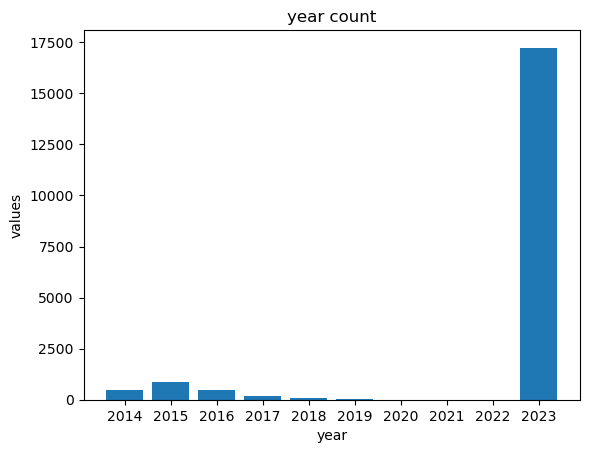

2131

In [128]:
#check for outliers by year
year_count=merged_df['year'].value_counts()
plt.bar(year_count.index, year_count)
plt.xlabel('year')
plt.ylabel('values')
plt.title('year count')
plt.xticks(year_count.index)
plt.show()
sum(merged_df.year<2023) #consider to remove all articles before 2023

In [131]:
#check the length of every headline in separation by is_fake value
#add column of headline length
merged_df['headline_length']=merged_df['headline'].apply(len)
merged_df

,headline,writers,genre,date,year,month,content,text_length,is_fake,headline_length
0,Knesset passes 2023-2024 state budget,JNS,Israel,2023-05-24,2023,5,Israel’s Knesset on Wednesday passed the state...,2253,NaN,37
1,Will flights from Israel to Mecca spark Temple...,Adam Eliyahu Berkowitz,Israel,2023-05-23,2023,5,Prime Minister Netanyahu was in direct contact...,6400,NaN,103
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,JNS,Israel,2023-05-23,2023,5,Rabbi Leo Dee is considering suing CNN chief i...,3946,NaN,49
3,Israeli Cabinet boosts funds for Kotel infrast...,JNS,Israel,2023-05-22,2023,5,The Israeli Cabinet on Sunday approved funding...,2850,NaN,53
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,JNS,Israel,2023-05-21,2023,5,During a visit to the Temple Mount in Jerusale...,1667,NaN,73
...,...,...,...,...,...,...,...,...,...,...
19361,Lebanon to take steps to fix finance sector sh...,Unknown,Middle East,2023-05-26,2023,5,Lebanon will work over the next year to addres...,2343,NaN,82
19362,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,Europe & Russia,2023-05-26,2023,5,Three migrants were killed and twelve others a...,1989,NaN,57
19363,Bahrain schools ordered by King to remove less...,Unknown,Middle East,2023-05-12,2023,5,Bahrain's educational institutions have been o...,1766,NaN,92
19364,China resumes construction of military base in...,Unknown,Middle East,2023-04-30,2023,4,China has resumed construction work on a milit...,1928,NaN,73


C:\Users\hadar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


4

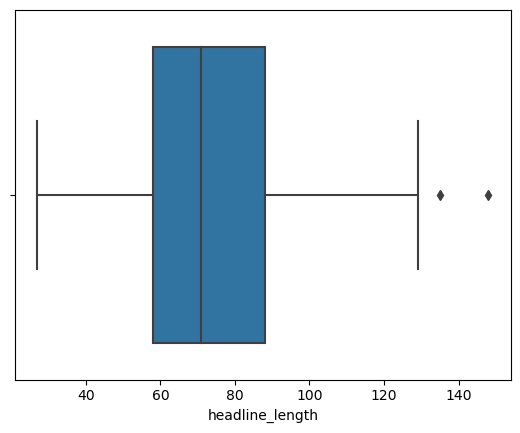

In [147]:
#check for outliers by text length
sns.boxplot(merged_df.headline_length)
sum(merged_df.headline_length>125) #consider to remove all articles with headlin length above 125

C:\Users\hadar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


614

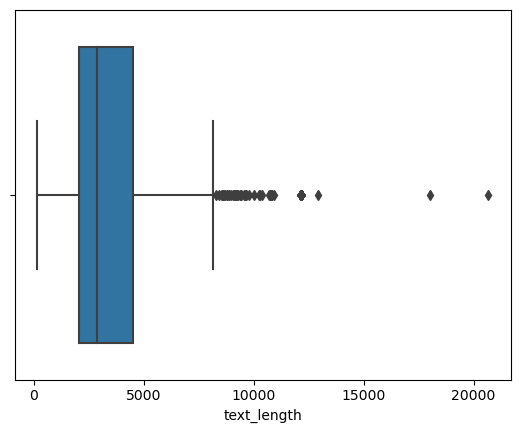

In [156]:
#check for outliers by text length
sns.boxplot(merged_df.text_length)
sum(merged_df.text_length>12000) #consider to remove all articles with content length above 12000 characters

In [121]:
#save merged dataframe in csv file
merged_df.to_csv('merged_df.csv',index=False)

In [181]:
##########
#Visualisation
##########

In [48]:
#read from csv file
merged_df=pd.read_csv('merged_df.csv')

In [60]:
is_fake_values=merged_df['is_fake'].value_counts()
is_fake_values

0.0    6917
1.0    2129
Name: is_fake, dtype: int64

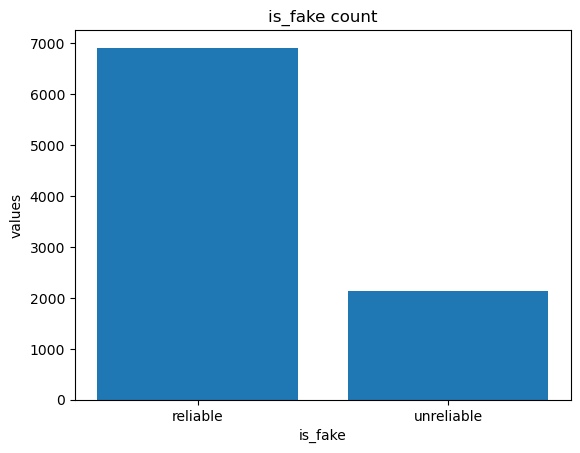

In [64]:
#Show how many reliable and unreliable data we've collected. Notice there are more articles that has no value and will be tested later
plt.bar(is_fake_values.index, is_fake_values)
plt.xlabel('is_fake')
plt.ylabel('values')
plt.title('is_fake count')
plt.xticks(is_fake_values.index,['reliable','unreliable'])
plt.show()

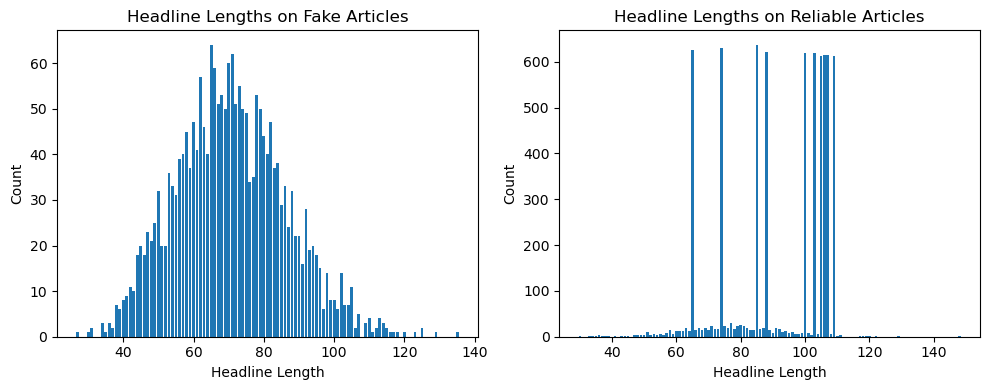

In [68]:
# Create a figure with a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

#saperate the data to 2 df by is_fake by value
fake_df=merged_df[merged_df['is_fake']==1]
reliable_df=merged_df[merged_df['is_fake']==0]

# Plot the fake df
axes[0].bar(fake_df['headline_length'].value_counts().index, fake_df['headline_length'].value_counts())
axes[0].set_xlabel('Headline Length')
axes[0].set_ylabel('Count')
axes[0].set_title('Headline Lengths on Fake Articles')

# Plot the reliable df
axes[1].bar(reliable_df['headline_length'].value_counts().index, reliable_df['headline_length'].value_counts())
axes[1].set_xlabel('Headline Length')
axes[1].set_ylabel('Count')
axes[1].set_title('Headline Lengths on Reliable Articles')

plt.tight_layout()
plt.show()

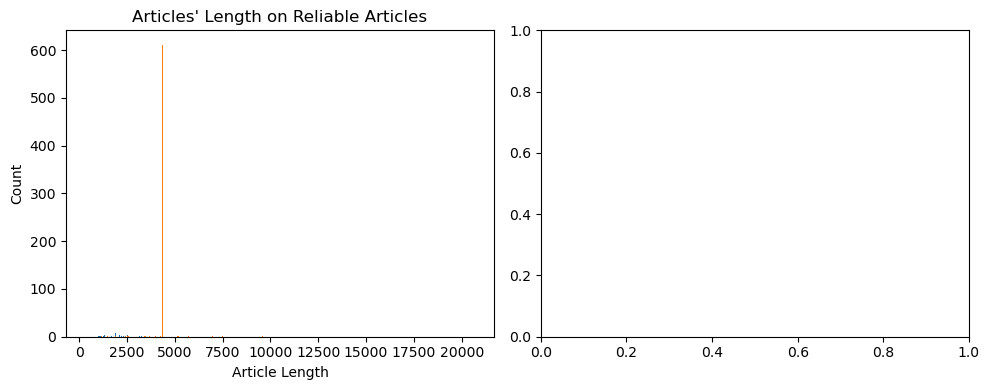

In [72]:
# Create a figure with a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

#saperate the data to 2 df by is_fake by value
fake_df=merged_df[merged_df['is_fake']==1]
reliable_df=merged_df[merged_df['is_fake']==0]

# Plot the fake df
axes[0].bar(fake_df['content_length'].value_counts().index, fake_df['content_length'].value_counts())
axes[0].set_xlabel('Article Length')
axes[0].set_ylabel('Count')
axes[0].set_title("Articles' Length on Fake Articles")

# Plot the reliable df
axes[0].bar(reliable_df['content_length'].value_counts().index, reliable_df['content_length'].value_counts())
axes[0].set_xlabel('Article Length')
axes[0].set_ylabel('Count')
axes[0].set_title("Articles' Length on Reliable Articles")

plt.tight_layout()
plt.show()

In [85]:
#We can see that there are outliers in the length columns we need to handle
def outlier_detection_iqr(df):
    num_cols = df.select_dtypes(include='number').columns.tolist()
    for col in num_cols:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1

        df.loc[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR ), col] = np.nan
        
    return df

In [86]:
outliers_df=outlier_detection_iqr(merged_df)
outliers_df

,headline,writers,genre,date,year,month,content,text_length,is_fake,headline_length
0,Knesset passes 2023-2024 state budget,JNS,Israel,2023-05-24,2023.0,5.0,Israel’s Knesset on Wednesday passed the state...,2253.0,NaN,37.0
1,Will flights from Israel to Mecca spark Temple...,Adam Eliyahu Berkowitz,Israel,2023-05-23,2023.0,5.0,Prime Minister Netanyahu was in direct contact...,6400.0,NaN,103.0
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,JNS,Israel,2023-05-23,2023.0,5.0,Rabbi Leo Dee is considering suing CNN chief i...,3946.0,NaN,49.0
3,Israeli Cabinet boosts funds for Kotel infrast...,JNS,Israel,2023-05-22,2023.0,5.0,The Israeli Cabinet on Sunday approved funding...,2850.0,NaN,53.0
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,JNS,Israel,2023-05-21,2023.0,5.0,During a visit to the Temple Mount in Jerusale...,1667.0,NaN,73.0
...,...,...,...,...,...,...,...,...,...,...
19361,Lebanon to take steps to fix finance sector sh...,Unknown,Middle East,2023-05-26,2023.0,5.0,Lebanon will work over the next year to addres...,2343.0,NaN,82.0
19362,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,Europe & Russia,2023-05-26,2023.0,5.0,Three migrants were killed and twelve others a...,1989.0,NaN,57.0
19363,Bahrain schools ordered by King to remove less...,Unknown,Middle East,2023-05-12,2023.0,5.0,Bahrain's educational institutions have been o...,1766.0,NaN,92.0
19364,China resumes construction of military base in...,Unknown,Middle East,2023-04-30,2023.0,NaN,China has resumed construction work on a milit...,1928.0,NaN,73.0


In [181]:
##########
#EDA
##########

In [ ]:
#Text Analysis

In [195]:
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    # Text Cleaning
    text = text.lower()
    text = ''.join(c for c in text if c.isalnum() or c.isspace())

    # Tokenization
    tokens = word_tokenize(text)

    # Stop Word Removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Join tokens back into a string
    processed_text = ' '.join(tokens)

    return processed_text


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hadar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hadar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [196]:
txt_df=merged_df
txt_df['processed_content'] = merged_df['content'].apply(preprocess_text)

In [197]:
txt_df

,headline,writers,genre,date,year,month,content,text_length,is_fake,processed_content
0,Knesset passes 2023-2024 state budget,JNS,Israel,2023-05-24,2023,5,israel’s knesset on wednesday passed the state...,2196,NaN,israel knesset wednesday pass state budget 202...
1,Will flights from Israel to Mecca spark Temple...,Adam Eliyahu Berkowitz,Israel,2023-05-23,2023,5,prime minister netanyahu was in direct contact...,6263,NaN,prime minist netanyahu direct contact saudi ar...
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,JNS,Israel,2023-05-23,2023,5,rabbi leo dee is considering suing cnn chief i...,3823,NaN,rabbi leo dee consid su cnn chief intern ancho...
3,Israeli Cabinet boosts funds for Kotel infrast...,JNS,Israel,2023-05-22,2023,5,the israeli cabinet on sunday approved funding...,2790,NaN,isra cabinet sunday approv fund upgrad infrast...
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,JNS,Israel,2023-05-21,2023,5,during a visit to the temple mount in jerusale...,1631,NaN,visit templ mount jerusalem sunday isra nation...
...,...,...,...,...,...,...,...,...,...,...
19361,Lebanon to take steps to fix finance sector sh...,Unknown,Middle East,2023-05-26,2023,5,lebanon will work over the next year to addres...,2288,NaN,lebanon work next year address defici polic co...
19362,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,Europe & Russia,2023-05-26,2023,5,three migrants were killed and twelve others a...,1946,NaN,three migrant kill twelv other still miss boat...
19363,Bahrain schools ordered by King to remove less...,Unknown,Middle East,2023-05-12,2023,5,bahrains educational institutions have been or...,1732,NaN,bahrain educ institut order king salman al kha...
19364,China resumes construction of military base in...,Unknown,Middle East,2023-04-30,2023,4,china has resumed construction work on a milit...,1895,NaN,china resum construct work militari base unit ...


In [198]:
vectorizer=CountVectorizer(stop_words="english")
freq_vec=vectorizer.fit_transform(txt_df['processed_content']).toarray() # the function requires as input an array of docs..
freqDist=dict(zip(vectorizer.get_feature_names(),freq_vec[0])) # create a dictionary from the first (and only) row
freqDist=dict(sorted(freqDist.items(), key=lambda item: item[1],reverse=True)) # ascending sort..

C:\Users\hadar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


C:\Users\hadar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


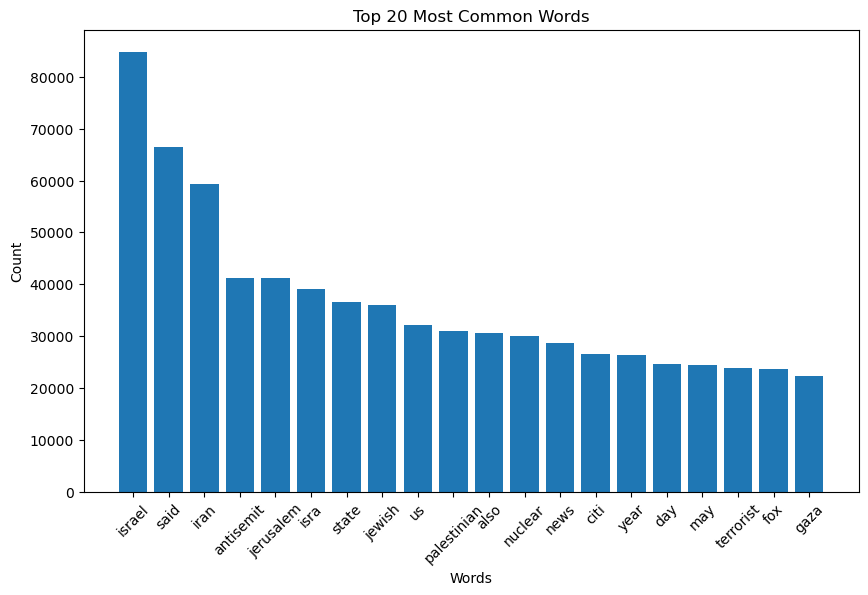

In [201]:
#create vecorizer and show the most frequent words in all articles. Used Chat GPT for this section
vectorizer=CountVectorizer()
X=vectorizer.fit_transform(txt_df['processed_content']) #Fit and transform the preprocessed text into a document-term matrix
word_counts=X.sum(axis=0) #Sum the word occurrences across all documents
feature_names=vectorizer.get_feature_names() #Get the feature names (words)
word_counts_df=pd.DataFrame({'Word': feature_names, 'Count': word_counts.flat})
word_counts_df=word_counts_df.sort_values('Count', ascending=False)#Sort the words based on their occurrence
top_words_df=word_counts_df.head(20)#Select the top 20 words with the highest occurrence count

# Plot the most common words
plt.figure(figsize=(10, 6))
plt.bar(top_words_df['Word'], top_words_df['Count'])
plt.xlabel('Words')
plt.ylabel('Count')
plt.title(f'Top 20 Most Common Words')
plt.show()

In [ ]:
# I want to see how many articles contains the word fox in it